## SARIMAX
Ref : https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')

import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['lines.linewidth']=1

%matplotlib inline

In [4]:
df = pd.read_excel("data/superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [5]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Preprocessing

In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [9]:
y = furniture['Sales'].resample('MS').mean()

In [10]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

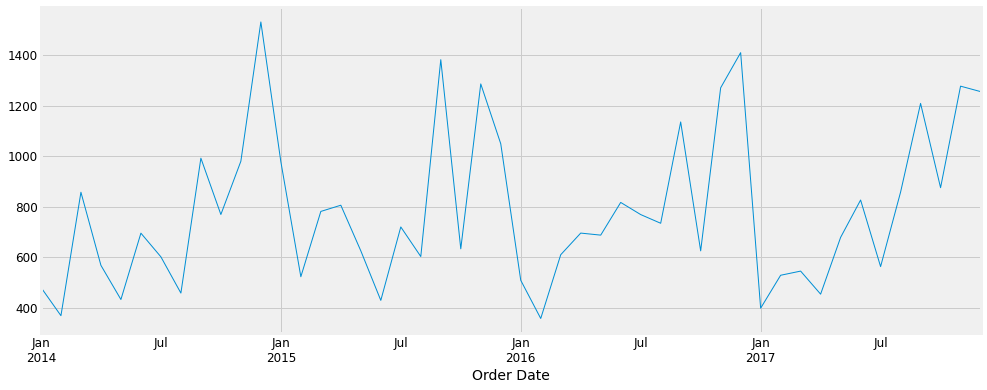

In [11]:
y.plot(figsize=(15, 6))
plt.show()

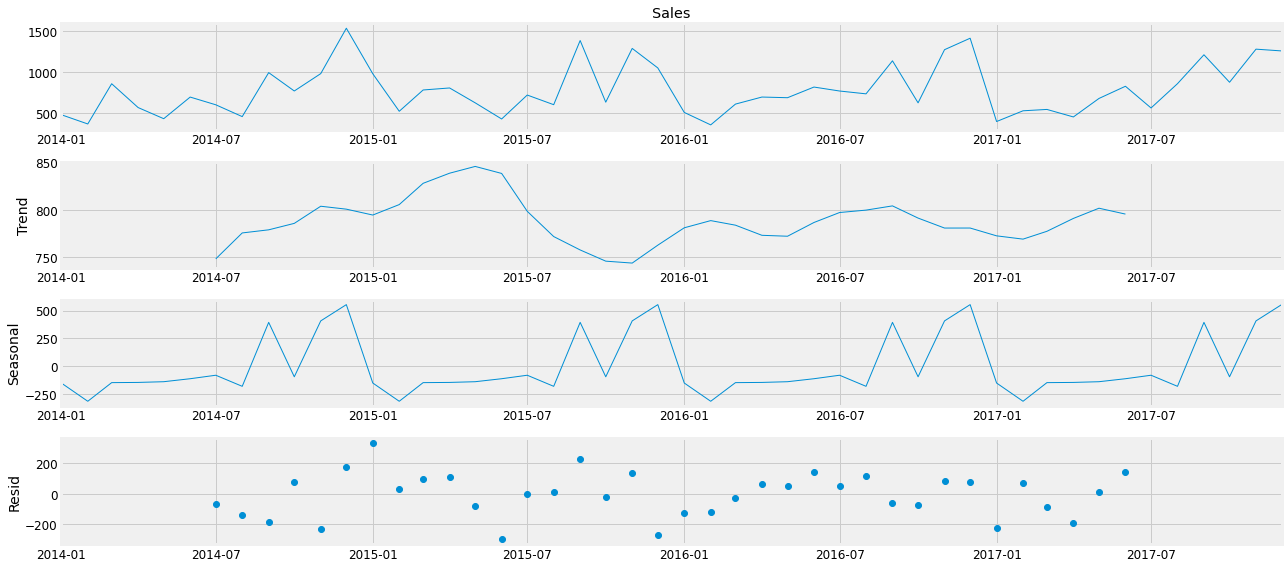

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# Selecting Values for p , d , q and m

One simple approach is to perform a grid search over multiple values of p,d,q,P,D,and Q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. 

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [14]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [15]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [19]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        
        except:
            print("param:",param)
            print("param_seasonal",param_seasonal)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1526.6646435881128
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793829


/Users/nsurawee/Documents/v_env/p3-8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1402.3936867800505
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341


/Users/nsurawee/Documents/v_env/p3-8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803029294
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.92522707581
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2900.5279890044303
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809134
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732927


/Users/nsurawee/Documents/v_env/p3-8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/nsurawee/Documents/v_env/p3-8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5730681144165
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576431208
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1420.8968510776567
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567198382
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.96712281679595
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


/Users/nsurawee/Documents/v_env/p3-8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1283.8048690707233
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.9113200151438
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817081
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2568.9604692368553
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482836
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806231680953
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442527
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2982.3212858304873
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417338
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5576621461241
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1378.8837536991703
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355


/Users/nsurawee/Documents/v_env/p3-8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.2077675160964
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935194
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1355.0241301172382
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084582
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.5842692143885
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.779444218597
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3132.313062242019
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.36851958151317
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.34221939659267
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876961
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2763.15984565311
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560021460404
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.75131881032274
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1412.2716724812103
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.20034222811347
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.2130611619097
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658784957
ARIMA

/Users/nsurawee/Documents/v_env/p3-8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345411
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.32649925080193
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835028
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2726.367540279938
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.47626876100463
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939422
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.5250354660781
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2625.787905160848
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439531316
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661014409179


### Minumum AIC : ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939422

In [20]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0953      0.310     -0.307      0.759      -0.703       0.513
ma.L1         -1.0000      0.414     -2.417      0.016      -1.811      -0.189
ma.S.L12      -0.3049      0.172     -1.777      0.076      -0.641       0.031
sigma2      2.476e+04   1.67e-05   1.48e+09      0.000    2.48e+04    2.48e+04


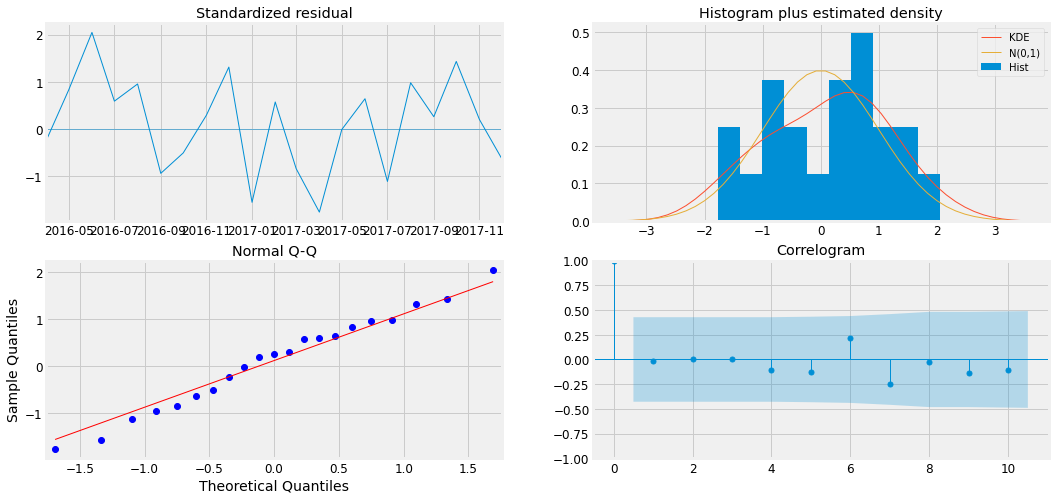

In [21]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validating ForeCasts



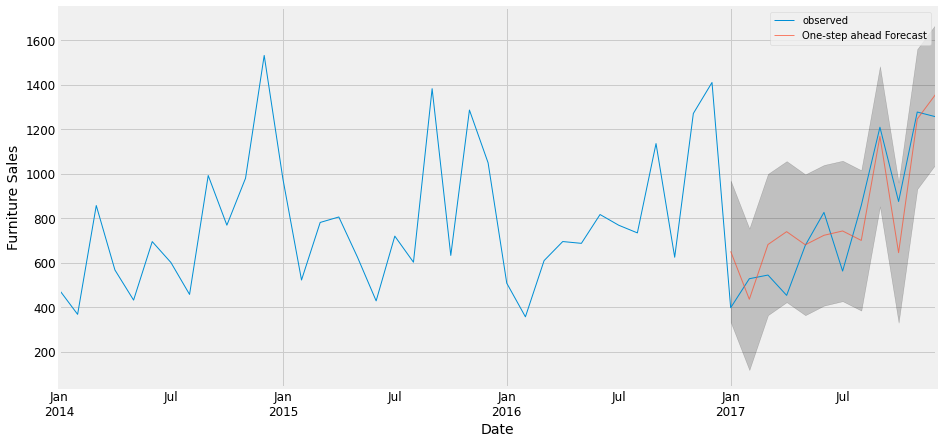

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()


In [23]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 25665.07


In [24]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 160.2


# Producing and visualizing forecasts

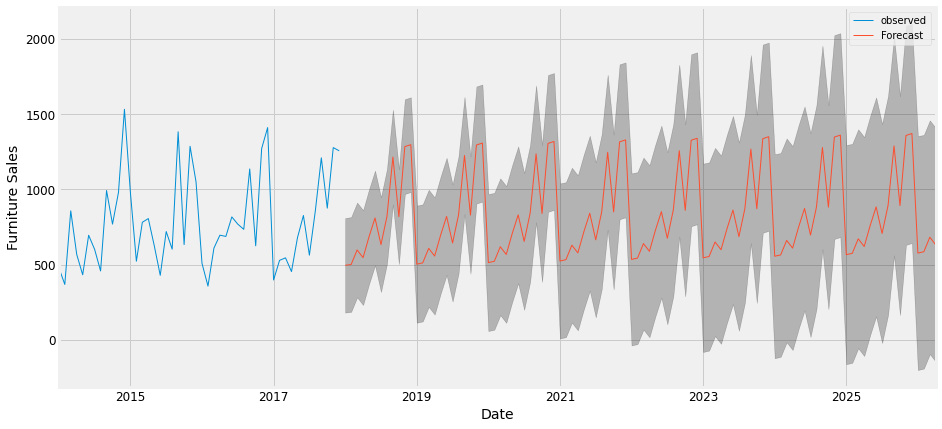

In [25]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()